## Imports

In [43]:
from cpc_pipeline import *
import random

from llm import LLM
gpt35t = LLM("gpt-3.5-turbo")
gpt4 = LLM("gpt-4")

## Make Problems

In [44]:
from make_quadratic_problems import make_quadratic_problem
problem_df = cpc_problems(make_quadratic_problem, {'max': range(5, 50, 5), 'factorable': [True, False]}, n=10)

Creating cpc_pipeline/make_quadratic_problem697572642.csv...


## Make Contexts

In [45]:
# prompt validated by switching analysis earlier
prompt = "Please find the roots of the quadratic equation {equation}. Start by trying to factor the equation. If you can't factor it, then use the quadratic formula. If you factor the equation successfully, do not use the quadratic formula." # removed instruction to say SWITCHING. swapped out for an alternative to enforce factoring first
# remember to force feed the model so it starts by attempting factoring! Otherwise switching will be too low.
false_start = "First, I'll try solving this equation by factoring."

def completion_35t(eq):
    try:
        return gpt35t.chat_completion_false_start(prompt.format(equation=eq), false_start=false_start)
    except Exception as e:
        print(f"Error while processing {eq}: {type(e)} {e}")
        return f"Exception: {type(e)} {e}"
    
def completion_4(eq):
    try:
        return gpt4.chat_completion_false_start(prompt.format(equation=eq), false_start=false_start)
    except Exception as e:
        print(f"Error while processing {eq}: {type(e)} {e}")
        return {'equation': eq, 'context': f"Exception: {type(e)} {e}"}
    
context_df_35t = cpc_contexts(problem_df, completion_35t)
context_df_4 = cpc_contexts(problem_df, completion_4)
assert not any(context_df_35t['context'].str.contains('Exception'))
assert not any(context_df_4['context'].str.contains('Exception'))

Creating cpc_pipeline/completion_35t1723546156.csv...
Creating cpc_pipeline/completion_44055386482.csv...


## Split and Judge Switching

In [46]:
from new_switch_utils import make_non_decreasing, original_4

def split_and_judge_row_gpt4(context, chunk_size):
    prefixes = [context[:pref_end] for pref_end in list(range(chunk_size, len(context), chunk_size))]+[context]
    measured_switching = [original_4(context, prefix) for prefix in prefixes]
    processed_switching = random.choice(make_non_decreasing(measured_switching))
    return prefixes, processed_switching

switching_df_35t = split_and_judge_switching(context_df_35t, split_and_judge_row_gpt4, 50)
switching_df_4 = split_and_judge_switching(context_df_4, split_and_judge_row_gpt4, 50)

Creating cpc_pipeline/split_and_judge_row_gpt42828181033.csv...
Creating cpc_pipeline/split_and_judge_row_gpt43619117240.csv...


## Plot Switch Distribution

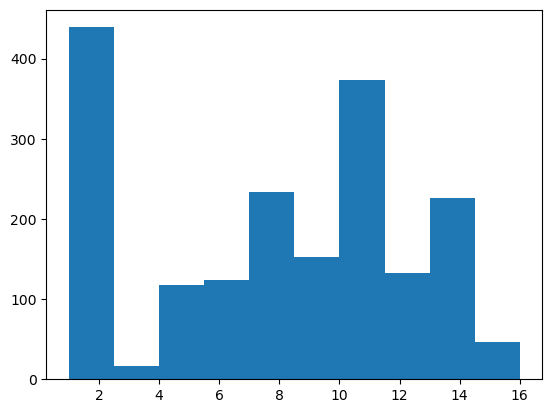

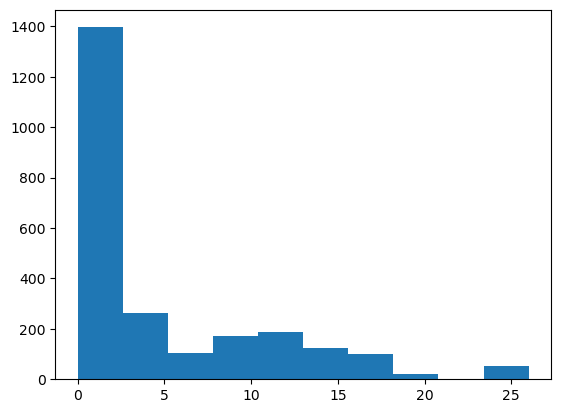

In [47]:
plt.hist(switching_df_35t['switch_index'])
plt.show()
plt.hist(switching_df_4['switch_index'])
plt.show()

## Judge CPC

In [48]:
from solver import perform_one_token_cpc, perform_cot_cpc
def gpt35t_1t(context):
    return perform_one_token_cpc(gpt35t, context)
def gpt35t_cot(context):
    return perform_cot_cpc(gpt35t, context)
def gpt4_1t(context):
    return perform_one_token_cpc(gpt4, context)
def gpt4_cot(context):
    return perform_cot_cpc(gpt4, context)

cpc_df_35t = judge_cpc(switching_df_35t, [gpt35t_1t, gpt35t_cot])
cpc_df_4 = judge_cpc(switching_df_4, [gpt4_1t, gpt4_cot])

Creating cpc_pipeline/cpc_3881784081.csv...
Creating cpc_pipeline/cpc_3518727587.csv...


## Check 1t/COT CPC Accuracy

In [49]:
print(sum(cpc_df_35t['gpt35t_cot'] == cpc_df_35t['gpt35t_1t'])/len(cpc_df_35t))
print(sum(cpc_df_4['gpt4_cot'] == cpc_df_4['gpt4_1t'])/len(cpc_df_4))

0.6681011296395912
0.9097682119205298


## Check COT Elicitation

In [50]:
print(sum([x.startswith('Yes') or x.startswith('No') for x in cpc_df_4['gpt4_cot_0']])/len(cpc_df_4))
print(sum([x.startswith('Yes') or x.startswith('No') for x in cpc_df_35t['gpt35t_cot_0']])/len(cpc_df_35t))

0.625
0.41527703066164606


## Sample COT CPC Thoughts

In [51]:
print(cpc_df_35t['gpt35t_cot_0'][0])
print(cpc_df_4['gpt4_cot_0'][0])

It seems like the factoring method may not be the most efficient approach for this particular equation. The equation is not a typical quadratic trinomial that can be easily factored with integer coefficients. It might be helpful to consider using the quadratic formula or completing the square as alternative methods. These approaches could potentially lead to a simpler and accurate solution to the problem.
The current approach is usually correct for solving a quadratic equation. We can proceed to solve this quadratic equation through factoring, completing the square, or using the quadratic formula.


## Overall Switch-Curve Plots

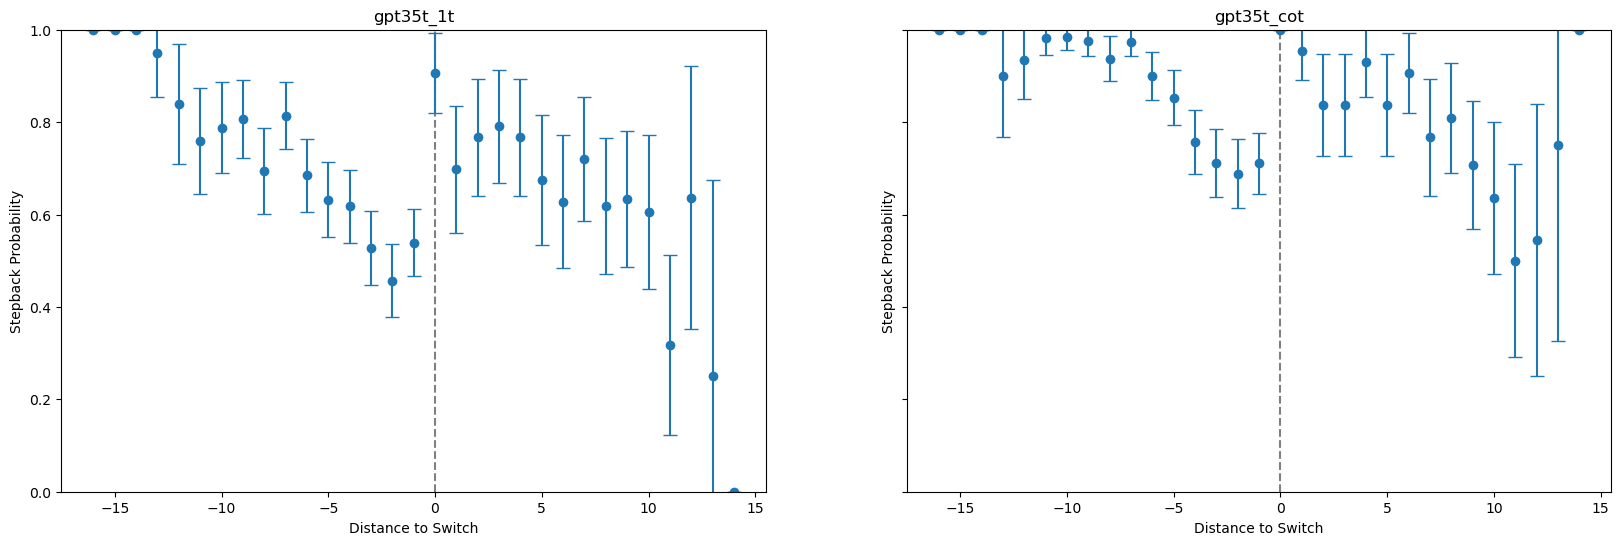

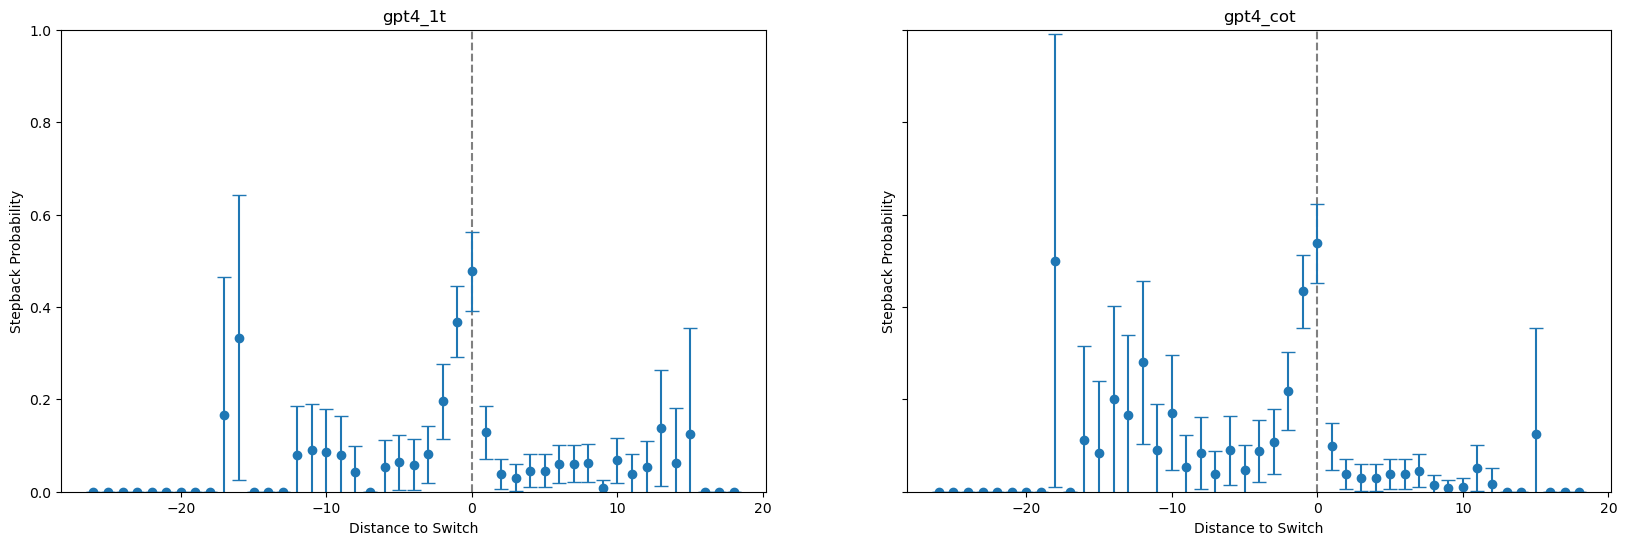

In [52]:
do_analysis(cpc_df_35t, [gpt35t_1t, gpt35t_cot])
do_analysis(cpc_df_4, [gpt4_1t, gpt4_cot])